In [1]:
from dicom_utils import main
import numpy as np 
import pandas as pd 
import os
import pydicom
import matplotlib.pyplot as plt
import assd_func as af
from skimage import morphology
from scipy import ndimage

In [2]:
# Folder has to be in format "Subject_ID -> CT and RTSTRUCT (all captial)"
dicom_dir = "1"
output_dir = "Output"
images, slices, contours, labels, dummy_mask = main(dicom_dir, output_dir)

In [16]:
labels.shape

(186, 512, 512, 25)

Labels has 25 rois which stands for different organs to select

Let's print out the list of rois

In [17]:
contour_table = pd.DataFrame()
number = []
name = []
for i in range(24):
    number.append(contours[i]["number"])
    name.append(contours[i]["name"])
#contour_table["number"] = number
contour_table["name"] = name

In [18]:
contour_table

,name
0,marked iso
1,a prostate
2,b SV
3,PTV
4,d rectum
5,e bladder
6,f Femural Heads
7,g nt avoid
8,fiducials
9,p ring


Find location of the contour where labels == 1 (prostate)

In [19]:
a = np.argwhere(labels==True)
a[a[..., 3] == 1][0]

array([ 63, 246, 245,   1], dtype=int64)

Let's try slice 63 and so on

(-0.5, 511.5, 511.5, -0.5)

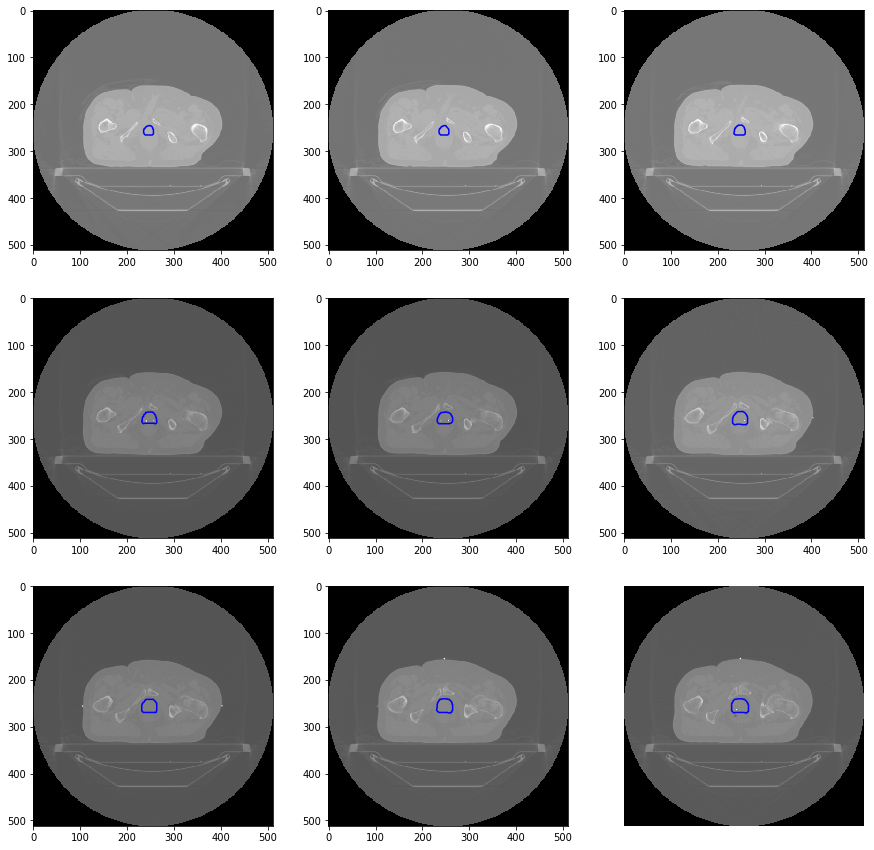

In [20]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i + 63, ...], cmap="gray")
    plt.contour(labels[..., 1][i + 63, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.axis('off')

In [21]:
target_img = images[63, ...]
target_label = labels[..., 1][63, ...]

In [22]:
frontal_target_img = images[0:, 250, 0:512]
frontal_target_label = labels[0:, 250, 0:512, 1]

In [23]:
frontal_target_label.shape

(186, 512)

In [24]:
sagittal_target_img = images[0:, 0:512, 260]
sagittal_target_label = labels[0:, 0:512, 260, 1]

(-0.5, 511.5, 185.5, -0.5)

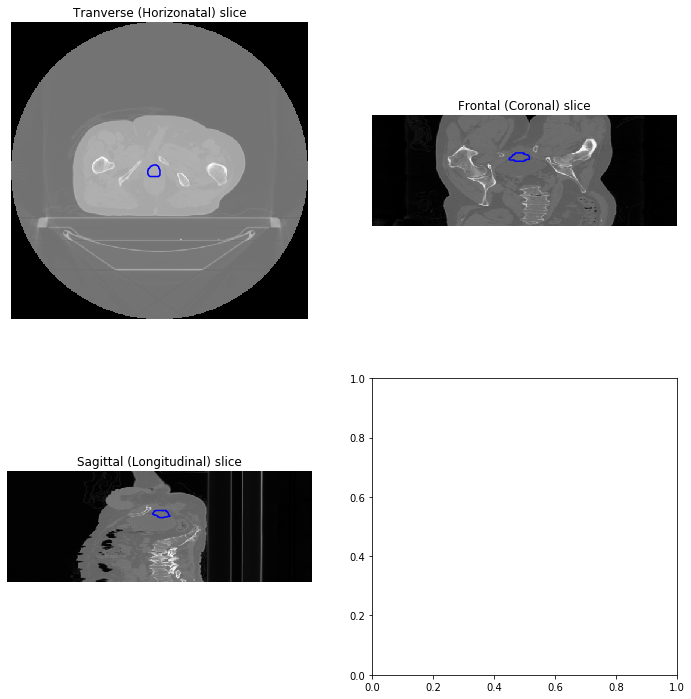

In [25]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")

fig, ax = plt.subplots(2, 2, figsize=[12, 12])

ax[0, 0].set_title("Tranverse (Horizonatal) slice")
ax[0, 0].imshow(target_img, cmap='gray')
ax[0, 0].contour(target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 0].set_xlabel("Orginal contour")
ax[0, 0].axis('off')

ax[0, 1].set_title("Frontal (Coronal) slice")
ax[0, 1].imshow(frontal_target_img, cmap='gray')
ax[0, 1].contour(frontal_target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 1].set_xlabel("Orginal contour")
ax[0, 1].axis('off')

ax[1, 0].set_title("Sagittal (Longitudinal) slice")
ax[1, 0].imshow(sagittal_target_img, cmap='gray')
ax[1, 0].contour(sagittal_target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 0].set_xlabel("Orginal contour")
ax[1, 0].axis('off')

In [3]:
def make_surface_contour(mask):
    interior = morphology.erosion(mask,np.ones([3,3])) # one last dilation 
    contour = np.where(interior==0, 1, 0)
    surface = contour*mask
    return surface, interior

In [27]:
src = target_img*target_label

In [28]:
#src, interior = make_surface_contour(mask)

## Sobel derivatives:
https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html

In [29]:
import random
mask = np.where(target_label!=0,4,0)
surface, interior = make_surface_contour(mask)
roi=target_img*mask
surface_cord = np.argwhere(surface != 0)

In [17]:
gray = surface

In [18]:
import cv2 as cv
# Gaussion blur
src = cv.GaussianBlur(src, (3, 3), 0)
ddepth = cv.CV_16S
gray = src #cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# New grad by Sobel derivatives
# Experiment ksize = 3, 5, 10
scale = 1
delta = 0
grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

In [19]:
def find_gradct(r, i):
    gradct = np.array(grad_x[r, i], grad_y[r, i])
    return gradct

window_name = ('Sobel Demo - Simple Edge Detector')
abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)
grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
grad
#cv.imshow(window_name, grad)
#cv.waitKey(0)

In [20]:
import cv2 as cv
# Gaussion blur
src = cv.GaussianBlur(src, (3, 3), 0)
ddepth = cv.CV_16S
gray = src #cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# New grad by Sobel derivatives
# Experiment ksize = 3, 5, 10
scale = 1
delta = 0
grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=5, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=5, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

## 3D Perturbations

In [21]:
def find_min_dist(start, surface_cord):
    dist_list = []
    for i in surface_cord:
        x_j = i[0]
        y_j = i[1]
        dist = ((x_j - start[0])**2)**0.5 + ((y_j - start[1])**2)**0.5
        dist_list.append(dist)
        min_dist = min(dist_list)
    return min_dist
    
def find_next_voxel(start, surface_cord):
    min_dist = find_min_dist(start, surface_cord)
    L = []
    for i in surface_cord:
        x_j = i[0]
        y_j = i[1]
        dist = ((x_j - start[0])**2)**0.5 +  ((y_j - start[1])**2)**0.5
        if dist == min_dist:
            next_voxel = [x_j, y_j]
    return next_voxel
    
def order_voxel_list(start, surface_cord, roi, a, voxelsize):
    surface_cord = surface_cord.tolist()
    L = [start]
    index = surface_cord.index(start)
    del surface_cord[index]
    for i in range(len(surface_cord)):
        try:
            next_voxel = find_next_voxel(start, surface_cord)
        except:
            for voxel in surface_cord:
                if i not in L:
                    next_voxel = voxel
                    
        L.append(next_voxel)
        start = next_voxel
        index = surface_cord.index(start)
        del surface_cord[index]
    '''    
    Fct_L = []
    for l in L:
        Fct_L.append(list(find_Fct(roi, l[0], l[1], a, voxelsize)))
    Fct_L = np.array(Fct_L)
    '''
    return L

In [22]:
def find_roi_slices(images, labels, i):
    roi_z = []
    for j in range(images.shape[0]):
        if True in np.unique(labels[..., i][j, ...] > 0):
            roi_z.append(j)
    return roi_z

In [23]:
def voxel_z_closest_list(start, roi_z, surface_cord, images, labels, gradct):
    z_roi_voxel_list = []
    grad_x_list = []
    grad_y_list = []
    for z in roi_z:
        target_img_next = images[z, ...]
        target_label_next = labels[..., 1][z, ...]
        mask = np.where(target_label_next !=0,4,0)
        surface_next, interior_next = make_surface_contour(mask)
        surface_cord_next = np.argwhere(surface_next != 0)
        next_voxel = find_next_voxel(start, surface_cord_next)
        z_roi_voxel_list.append(next_voxel)
        grad_x = gradct[0]
        grad_y = gradct[1]
        grad_x_list.append(grad_x[next_voxel[0], next_voxel[1]])
        grad_y_list.append(grad_y[next_voxel[0], next_voxel[1]])
    avg_grad_x = sum(grad_x_list)/len(roi_z)
    avg_grad_y = sum(grad_y_list)/len(roi_z) 
    avg_grad = [avg_grad_x, avg_grad_y]
    return z_roi_voxel_list, avg_grad

In [24]:
def find_z_list(roi_z, surface_cord, images, labels):
    z_surface_list = []
    avg_grad_surface_list = []
    gradct = find_gradct(r, i)
    for start in surface_cord:
        z_roi_voxel_list, avg_grad = voxel_z_closest_list(start, roi_z, surface_cord, images, labels, gradct)
        z_surface_list.append(z_roi_voxel_list)
        avg_grad_surface_list.append(avg_grad)
    return z_surface_list, avg_grad_surface_list

In [25]:
def find_i0(images, labels, organ_i, surface_cord):
    roi_z = find_roi_slices(images, labels, organ_i)
    z_list, avg_grad_surface_list = find_z_list(roi_z, surface_cord, images, labels)
    grad_dist = list((np.array(avg_grad_surface_list)[..., 0]**2) + (np.array(avg_grad_surface_list)[..., 1]**2)) #magnitude
    i0 = grad_dist.index(min(grad_dist))
    return i0

In [26]:
def find_i0(images, labels, organ_i, surface_cord):
    roi_z = find_roi_slices(images, labels, organ_i)
    z_list, avg_grad_surface_list = find_z_list(roi_z, surface_cord, images, labels)
    grad_dist = list((np.array(avg_grad_surface_list)[..., 0]**2) + (np.array(avg_grad_surface_list)[..., 1]**2)) #magnitude
    i0 = grad_dist.index(min(grad_dist))
    return i0

def get_circular_index(i, R):
    if i < 0:
        r = np.ceil(-i/R)*R + i
    else:
        r = i % R
    return r

def calc_circular_dist(i, i0, R):
    circular_dist = min([(i-i0)**2, (i-i0 - R)**2,  (i-i0 + R)**2])
    return circular_dist

def calc_tg(r, i, start, surface_cord, a, voxelsize, roi, w, ismax):
    L, Fct_L = order_voxel_list(start, surface_cord, roi, a, voxelsize)
    R = len(L)
    i0 = find_i0(images, labels, organ_i, surface_cord)
    w0 = R/w
    i = L.index([r, i])
    #i = i - i0
    #i = get_circular_index(i, R)
    r = np.arange(i)
    circular_dist = calc_circular_dist(i, i0, R)
    t = 1/(np.sqrt(2*np.pi)*w0)*np.exp(-(circular_dist)/(2*w0**2)) 
    return t

def find_tg(L, start, surface_cord, a, voxelsize, roi, w, ismax):
    tg_list = []
    for i in range(len(L)):
        tg = calc_tg(L[i][0], L[i][1], start, surface_cord, a, voxelsize, roi, w, ismax)
        tg_list.append(tg)
    t = np.array(tg_list) - np.mean(tg_list) 
    return t*1000

## Combining to orginal code

In [27]:
target_img1 = images[75, ...]
target_label1 = labels[..., 1][75, ...]

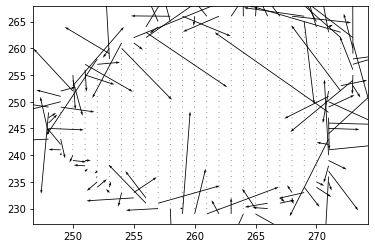

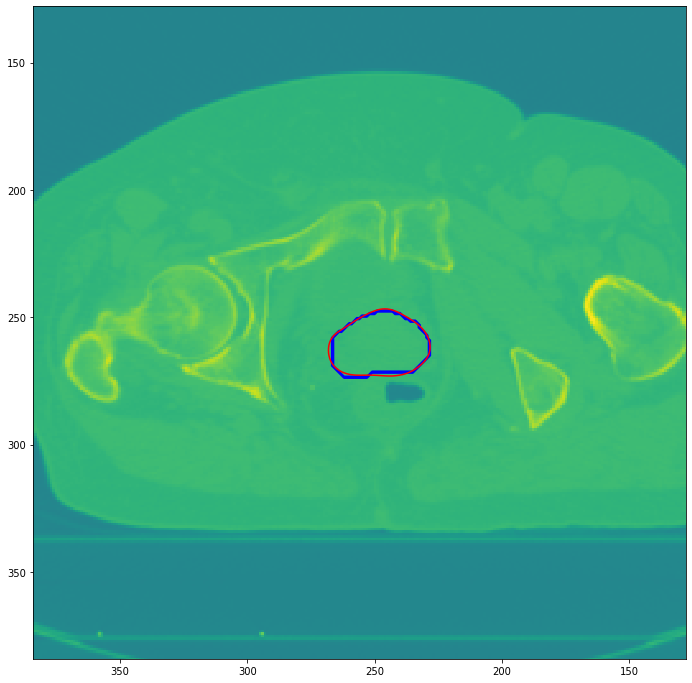

In [28]:
import assd_func_v2 as af_2
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 5
SD=[c*1.7, c*2, c*2.5]
w = 6
k = 45
circles = 3
organ_i = 1
seed=123
dx, dy, mask, t, L = af_2.assd(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True, blur=True)
du_1 = af_2.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=False)

# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 5
SD=[c*1.7, c*2, c*2.5]
w = 6
k = 45
circles = 3
organ_i = 1
seed=123
dx, dy, mask, t, L = assd(target_img1, target_label1, images, labels, organ_i, voxelsize, a, SD, circles, seed, k, w, smooth=True, blur=False, ismax=False, Sobel=True)
du_1 = af.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=False)

In [29]:
target_img1 = images[75, ...]
target_label1 = labels[..., 1][75, ...]

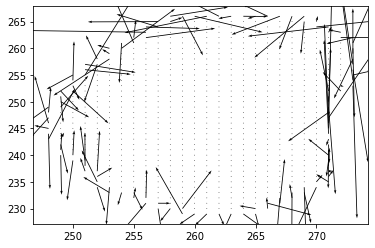

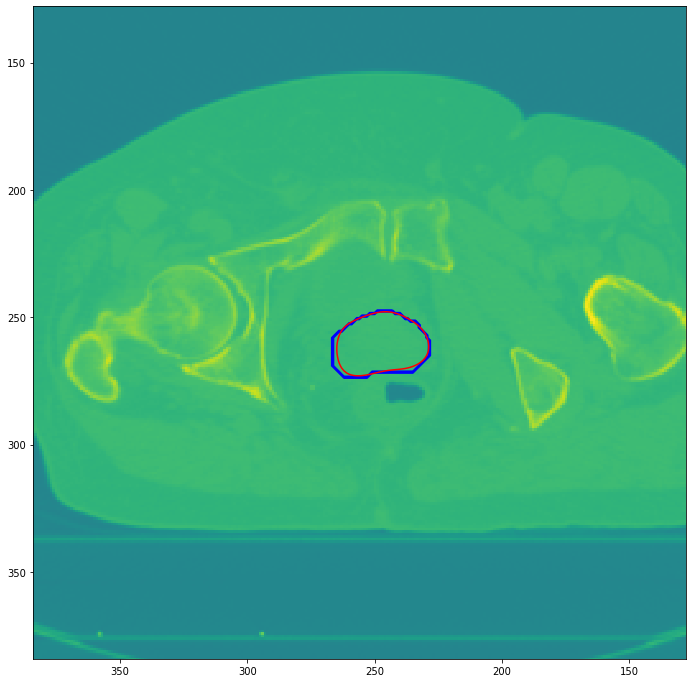

In [33]:
import assd_func_Sobel as af_Sobel
# roi = target_label*target_img
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 15
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 25
circles = 3
organ_i = 1
seed=123
dx, dy, mask, t, L = af_Sobel.assd_Sobel(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
du_1 = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=True)
#du_1 = np.where(du_1 < 0.5, 0, 4)

In [36]:
frontal_target_img = images[0:100, 250, 0:512]
frontal_target_label = labels[..., 1][0:100, 250, 0:512]

In [39]:
dx, dy, mask, t, L = af_Sobel.assd_Sobel(frontal_target_img, frontal_target_label, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
frontal_du = af.plotting_assd(dx, dy, mask, frontal_target_img, quiver=False, plot=False, display=False)
frontal_du = np.where(frontal_du < 0.5, 0, 4)

In [40]:
sagittal_target_img = images[0:90, 0:512, 260]
sagittal_target_label = labels[..., 1][0:90, 0:512, 260]

In [42]:
dx, dy, mask, t, L = af_Sobel.assd_Sobel(sagittal_target_img, sagittal_target_label, voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
sagittal_du = af.plotting_assd(dx, dy, mask, sagittal_target_img, quiver=False, plot=False, display=False)
sagittal_du = np.where(sagittal_du < 0.5, 0, 4)

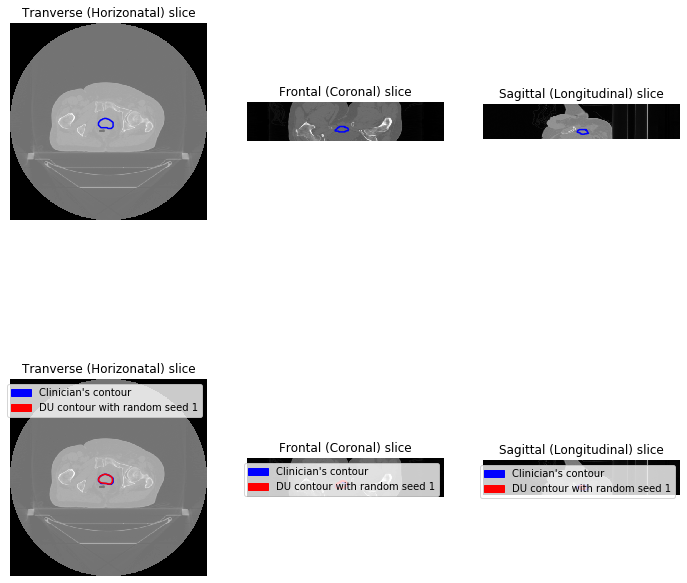

In [46]:
blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")

fig, ax = plt.subplots(2, 3, figsize=[12, 12])

ax[0, 0].set_title("Tranverse (Horizonatal) slice")
ax[0, 0].imshow(target_img1, cmap='gray')
ax[0, 0].contour(target_label1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 0].set_xlabel("Orginal contour")
ax[0, 0].axis('off')

ax[0, 1].set_title("Frontal (Coronal) slice")
ax[0, 1].imshow(frontal_target_img, cmap='gray')
ax[0, 1].contour(frontal_target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 1].set_xlabel("Orginal contour")
ax[0, 1].axis('off')

ax[0, 2].set_title("Sagittal (Longitudinal) slice")
ax[0, 2].imshow(sagittal_target_img, cmap='gray')
ax[0, 2].contour(sagittal_target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[0, 2].set_xlabel("Orginal contour")
ax[0, 2].axis('off')

ax[1, 0].set_title("Tranverse (Horizonatal) slice")
ax[1, 0].imshow(target_img1, cmap='gray')
ax[1, 0].contour(target_label1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 0].contour(du_1, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='red')
ax[1, 0].set_xlabel("DU contour")
ax[1, 0].legend(handles=[ blue_patch, red_patch])
ax[1, 0].axis('off')

ax[1, 1].set_title("Frontal (Coronal) slice")
ax[1, 1].imshow(frontal_target_img, cmap='gray')
ax[1, 1].contour(frontal_target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 1].contour(frontal_du, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='red')
ax[1, 1].set_xlabel("DU contour")
#ax[1, 1].set_xlim(0, 50)
#ax[1, 1].set_ylim(300, 200)
ax[1, 1].legend(handles=[ blue_patch, red_patch])
ax[1, 1].axis('off')

ax[1, 2].set_title("Sagittal (Longitudinal) slice")
ax[1, 2].imshow(sagittal_target_img, cmap='gray')
ax[1, 2].contour(sagittal_target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='blue')
ax[1, 2].contour(sagittal_du, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors='red')
ax[1, 2].set_xlabel("DU contour")
#ax[1, 2].set_xlim(0, 50)
#ax[1, 2].set_ylim(300, 200)
ax[1, 2].legend(handles=[ blue_patch, red_patch])
ax[1, 2].axis('off')

plt.show()

In [34]:
assd_contour = []

for i in range(12):
    if i != 7:
        dx, dy, mask, t, L  = af_Sobel.assd_Sobel(images[65 + i, ...], labels[..., 1][65 + i, ...], voxelsize, a, SD, circles, seed, k, w, images, labels, 1, smooth=True)
        du = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=False, plot=False)
        du_2 = np.where(du < 0.5, 0, 4)
        assd_contour.append(list(du_2)) #surface
assd_contour = np.array(assd_contour)


(200.0, 300.0, 300.0, 200.0)

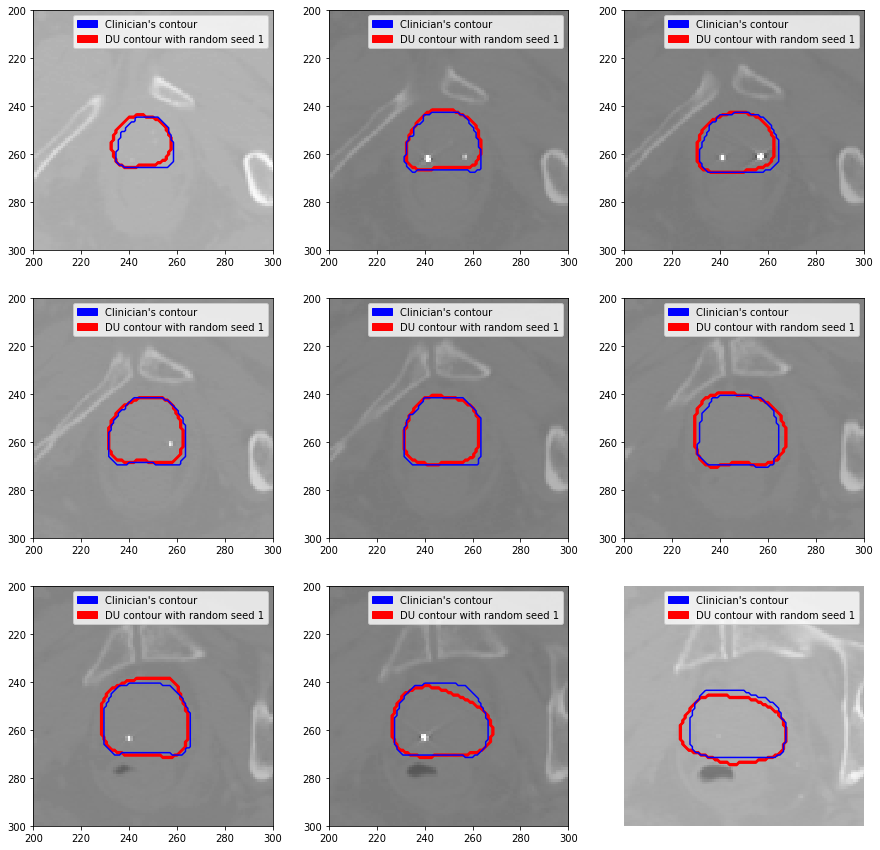

In [35]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[65 + i , ...], cmap="gray")
    plt.contour(assd_contour[i, ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels[..., 1][65 + i, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(200, 300)
    plt.ylim(300, 200)
    blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    plt.legend(handles=[ blue_patch, red_patch])
    
plt.axis('off')

# symmetry option

In [4]:
target_img1 = images[75, ...]
target_label1 = labels[..., 1][75, ...]

In [5]:
import assd_func_Sobel as af_Sobel
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 15
SD=[c*1.7, c*2, c*2.5]
w = 2
k = 25
circles = 3
organ_i = 1
seed=123

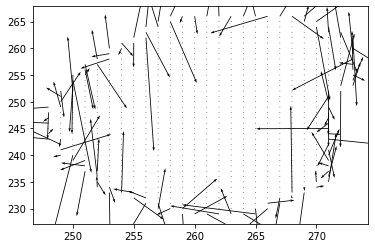

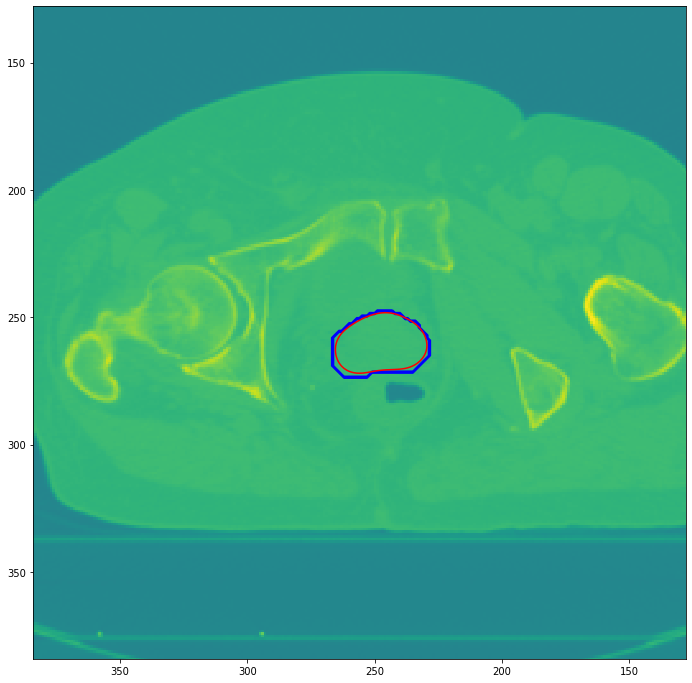

In [6]:
sym="y-axis"
dx, dy, mask, t, L = af_Sobel.assd_sym(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, sym, images, labels, 1, smooth=True)
sym_y_du = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=True)

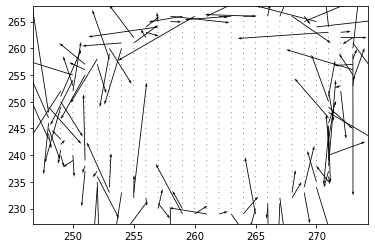

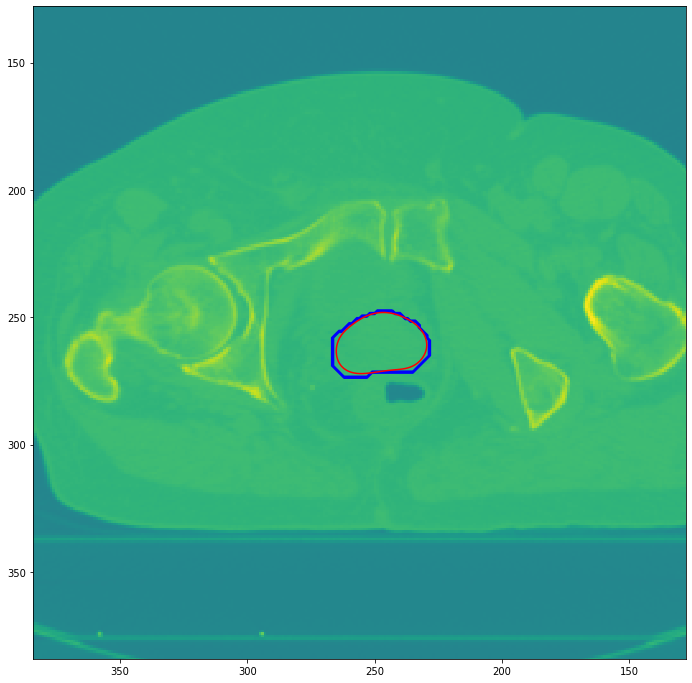

In [8]:
sym2="x-axis"
dx, dy, mask, t, L = af_Sobel.assd_sym(target_img1, target_label1, voxelsize, a, SD, circles, seed, k, w, sym2, images, labels, 1, smooth=True)
sym_x_du = af_Sobel.plotting_assd(dx, dy, mask, target_img1, quiver=True, plot=True, display=True)